<a href="https://colab.research.google.com/github/AlexVonSchwerdtner/my-first-repository/blob/main/CNN_Homework_2_Part_1_Alex%26Chun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
7.448040438999996
GPU (s):
0.10993206099999497
GPU speedup over CPU: 67x


#**HOMEWORK 2: REAL ESTATE PRICE PREDICTION (Total: / 25 points)**

# *Names: (Student One, Student Two)*

Make sure that you answer the two conceptual questions provided at the front of the notebook (edit the XXX response sections to provide your answers). You probably want to answer these last, after you finish the hands-on portion of the assignment. 

#*Background: Use Case*

Your task here is to use the supplied dataset describing homes, including four photos per home and some other structured features, along with an associated home sale price label, to try to fit a predictive model of sale price.

The use case here is as follows. Your customers are individual sellers, buyers, and real estate agent, who wishes to set their sale price, or their offer price on a new home. You can assume the user will always have these features available to them at the time of prediction (i.e., the four photo types in question, as well as the structured features). 

You must evaluate your model's performance using 5-fold cross validation. I will evaluate your model's performance (in terms of MAE) based on validation loss.

#**Answers to Written Questions (2 points)**

**Question 1: Why is it necessaty to resize the images? What impact, conceptually, would the choice of image size have on the prediction task, computationally / practically, but also in terms of prediction performnace (note: I'm not asking you try out different sizes to see what happens; I'm asking you to think about 'why' a choice of a smaller vs. larger image resizing would matter.)**

It is necessary to resize the images because we want to keep all images at same size to fit into the CNN model. The larger the fixed size, the less shrinking required. Less shrinking means less deformation of features and patterns inside the image. This will mitigate the classification accuracy degradation due to deformations. However, large images not only occupy more space in the memory but also result in a larger neural network. Thus, increasing both the space and time complexity. It is obvious now that choosing this fixed size for images is a matter of tradeoff between computational efficiency and accuracy.

**Question 2: Are there any predictors that you decided to discard here (numeric or image-based)? Why or why not; what did you consider when making these choices? Did you add any features? What, and why?**

We decided to only discard price from predictors because it is the label. We keep all images, zipcode, number of bathrooms and bedrooms, and area, because these are important factors for buyers to consider the price of houses.

#**Importing the Data**

I've provided some starter code for importing the data...

Mounted at /content/drive
The shape of our kitchen image array is (535, 250, 250, 3)


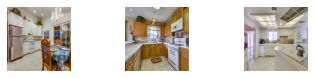

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from tensorflow.keras import layers

drive.mount('/content/drive', force_remount=True)

# Replace with your basepath to the extracted dataset in your Google Drive
basePath = 'drive/MyDrive/MSBA/BA865 - Intro to Neural Nets/Week 5/datasets/Houses Dataset'

# These are the column headers for the home characteristics data.
cols = ['bedrooms','bathrooms','area','zipcode','price']

# We first pull in the numeric features for houses from the text file.
numericData = pd.read_csv(f'{basePath}/all/HousesInfo.txt', sep=" ", header=None, names=cols)

# Pulling out the labels
labels = numericData['price']

# we can PLAY WITH THIS
image_size = (250,250)

# Reading the images into memory may take a minute - be patient :).
def read_images(imageType):
  image_list = []
  for file in glob.glob(f"{basePath}/all/{imageType}/*"):
    im=Image.open(file)
    im=im.resize(size=image_size)
    image_list.append(np.divide(np.array(im),255))
  return np.stack(image_list)

front_image = read_images("frontal")
bathroom_image = read_images("bathroom")
bedroom_image = read_images("bedroom")
kitchen_image = read_images("kitchen")

print(f'The shape of our kitchen image array is {kitchen_image.shape}')

# Our 535 houses' images are all now in memory as 200x200 pictures, with 3 channels (RGB). Feel free to change the image size.
for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(kitchen_image[i])
    plt.axis("off")

In [5]:
print(f'The shape of our bedroom image array is {bedroom_image.shape}')
print(f'The shape of our bathroom image array is {bathroom_image.shape}')

The shape of our bedroom image array is (535, 250, 250, 3)
The shape of our bathroom image array is (535, 250, 250, 3)


In [6]:
numericData.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36373,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [7]:
variables = numericData.drop(columns = ['price'])

In [8]:
# one-hot encoding for usertype column
variables = pd.get_dummies(variables, columns=["zipcode"])

Shuffle the different arrays, in unison (preserving row ordering across the arrays).

In [9]:
shuffled_indices= np.arange(front_image.shape[0])
np.random.shuffle(shuffled_indices)

front_image = front_image[shuffled_indices]
kitchen_image = kitchen_image[shuffled_indices]
bathroom_image = bathroom_image[shuffled_indices]
bedroom_image = bedroom_image[shuffled_indices]
numericData = numericData.iloc[shuffled_indices]
variables = variables.iloc[shuffled_indices]
labels = labels[shuffled_indices]

#**Create a Multi-Modal NN from Scratch (13 points)**

#*Define Your Model*

Provide your code to implement a multi-modal NN. You should evaluate your model's loss in terms of mean absolute error (MAE).

In [10]:
def build_model():

    # Define image input branch for front.
    front_image_input = layers.Input(shape=(front_image.shape[1],front_image.shape[2],front_image.shape[3]), name="front")
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(front_image_input)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    front_image_output = layers.flatten()(x) # Instead of pooling the filters down to scalars, you could also use layers.Flatten() here.

    # Define image input branch for bathroom.
    bathroom_image_input = layers.Input(shape=(bathroom_image.shape[1],bathroom_image.shape[2],bathroom_image.shape[3]), name="bathroom")
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(bathroom_image_input)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    bathroom_image_output = layers.flatten()(x) # Instead of pooling the filters down to scalars, you could also use layers.Flatten() here.

    # Define image input branch for bedroom.
    bedroom_image_input = layers.Input(shape=(bedroom_image.shape[1],bedroom_image.shape[2],bedroom_image.shape[3]), name="bedroom")
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(bedroom_image_input)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    bedroom_image_output = layers.flatten()(x) # Instead of pooling the filters down to scalars, you could also use layers.Flatten() here.

    # Define image input branch for kitchen.
    kitchen_image_input = layers.Input(shape=(kitchen_image.shape[1],kitchen_image.shape[2],kitchen_image.shape[3]), name="kitchen")
    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(kitchen_image_input)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
    kitchen_image_output = layers.flatten()(x) # Instead of pooling the filters down to scalars, you could also use layers.Flatten() here.

    # Define image input branch for numeric variables.
    numeric_input = keras.layers.Input(shape=variables.shape[1],name="numeric_input")
    h = keras.layers.BatchNormalization()(numeric_input)
    h = keras.layers.Dense(10, activation="relu")(h)
    h = keras.layers.BatchNormalization()(h)
    h = keras.layers.Dense(10, activation="relu")(h)
    h = keras.layers.BatchNormalization()(h)
    h = keras.layers.Dense(10, activation="relu")(h)
    h = keras.layers.BatchNormalization()(h)
    h = keras.layers.Dense(10, activation="relu")(h)
    h = keras.layers.BatchNormalization()(h)
    h = keras.layers.Dense(1)(h)
    numeric_output = layers.Dense(5,activation="relu")(h) #Another option might be to have dense matrices that are wider, and you reshape them to 28x28x3 to add.


    merge = layers.Concatenate()([front_image_output, bathroom_image_output, bedroom_image_output, kitchen_image_output, numeric_output])
    x = layers.Dense(5, activation="relu")(merge)
    final_output = layers.Dense(1)(x)

    model = keras.Model(inputs=[front_image_input, bathroom_image_input, bedroom_image_input, kitchen_image_input, numeric_input],outputs=final_output)

    model.compile(optimizer="adam",
                  loss="mae",
                  metrics=['mae'])

    return model

In [11]:
model = build_model()

history = model.fit(x=[front_image, bathroom_image, bedroom_image, kitchen_image, variables], y=labels, validation_split=0.33, epochs=20, batch_size=8)

Epoch 1/20
45/45 [==============================] - 18s 276ms/step - loss: 477384.5312 - mae: 477384.5312 - val_loss: 311528.5000 - val_mae: 311528.5000
Epoch 2/20
45/45 [==============================] - 10s 231ms/step - loss: 339733.7500 - mae: 339733.7500 - val_loss: 299953.0000 - val_mae: 299953.0000
Epoch 3/20
45/45 [==============================] - 10s 231ms/step - loss: 346425.3125 - mae: 346425.3125 - val_loss: 294107.1250 - val_mae: 294107.1250
Epoch 4/20
45/45 [==============================] - 10s 231ms/step - loss: 357318.3438 - mae: 357318.3438 - val_loss: 306052.2812 - val_mae: 306052.2812
Epoch 5/20
45/45 [==============================] - 10s 232ms/step - loss: 334604.3438 - mae: 334604.3438 - val_loss: 303690.5938 - val_mae: 303690.5938
Epoch 6/20
45/45 [==============================] - 10s 231ms/step - loss: 337022.5312 - mae: 337022.5312 - val_loss: 302111.0312 - val_mae: 302111.0312
Epoch 7/20
45/45 [==============================] - 10s 232ms/step - loss: 338281.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_input (InputLayer)     [(None, 52)]         0           []                               
                                                                                                  
 front (InputLayer)             [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 bathroom (InputLayer)          [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                              

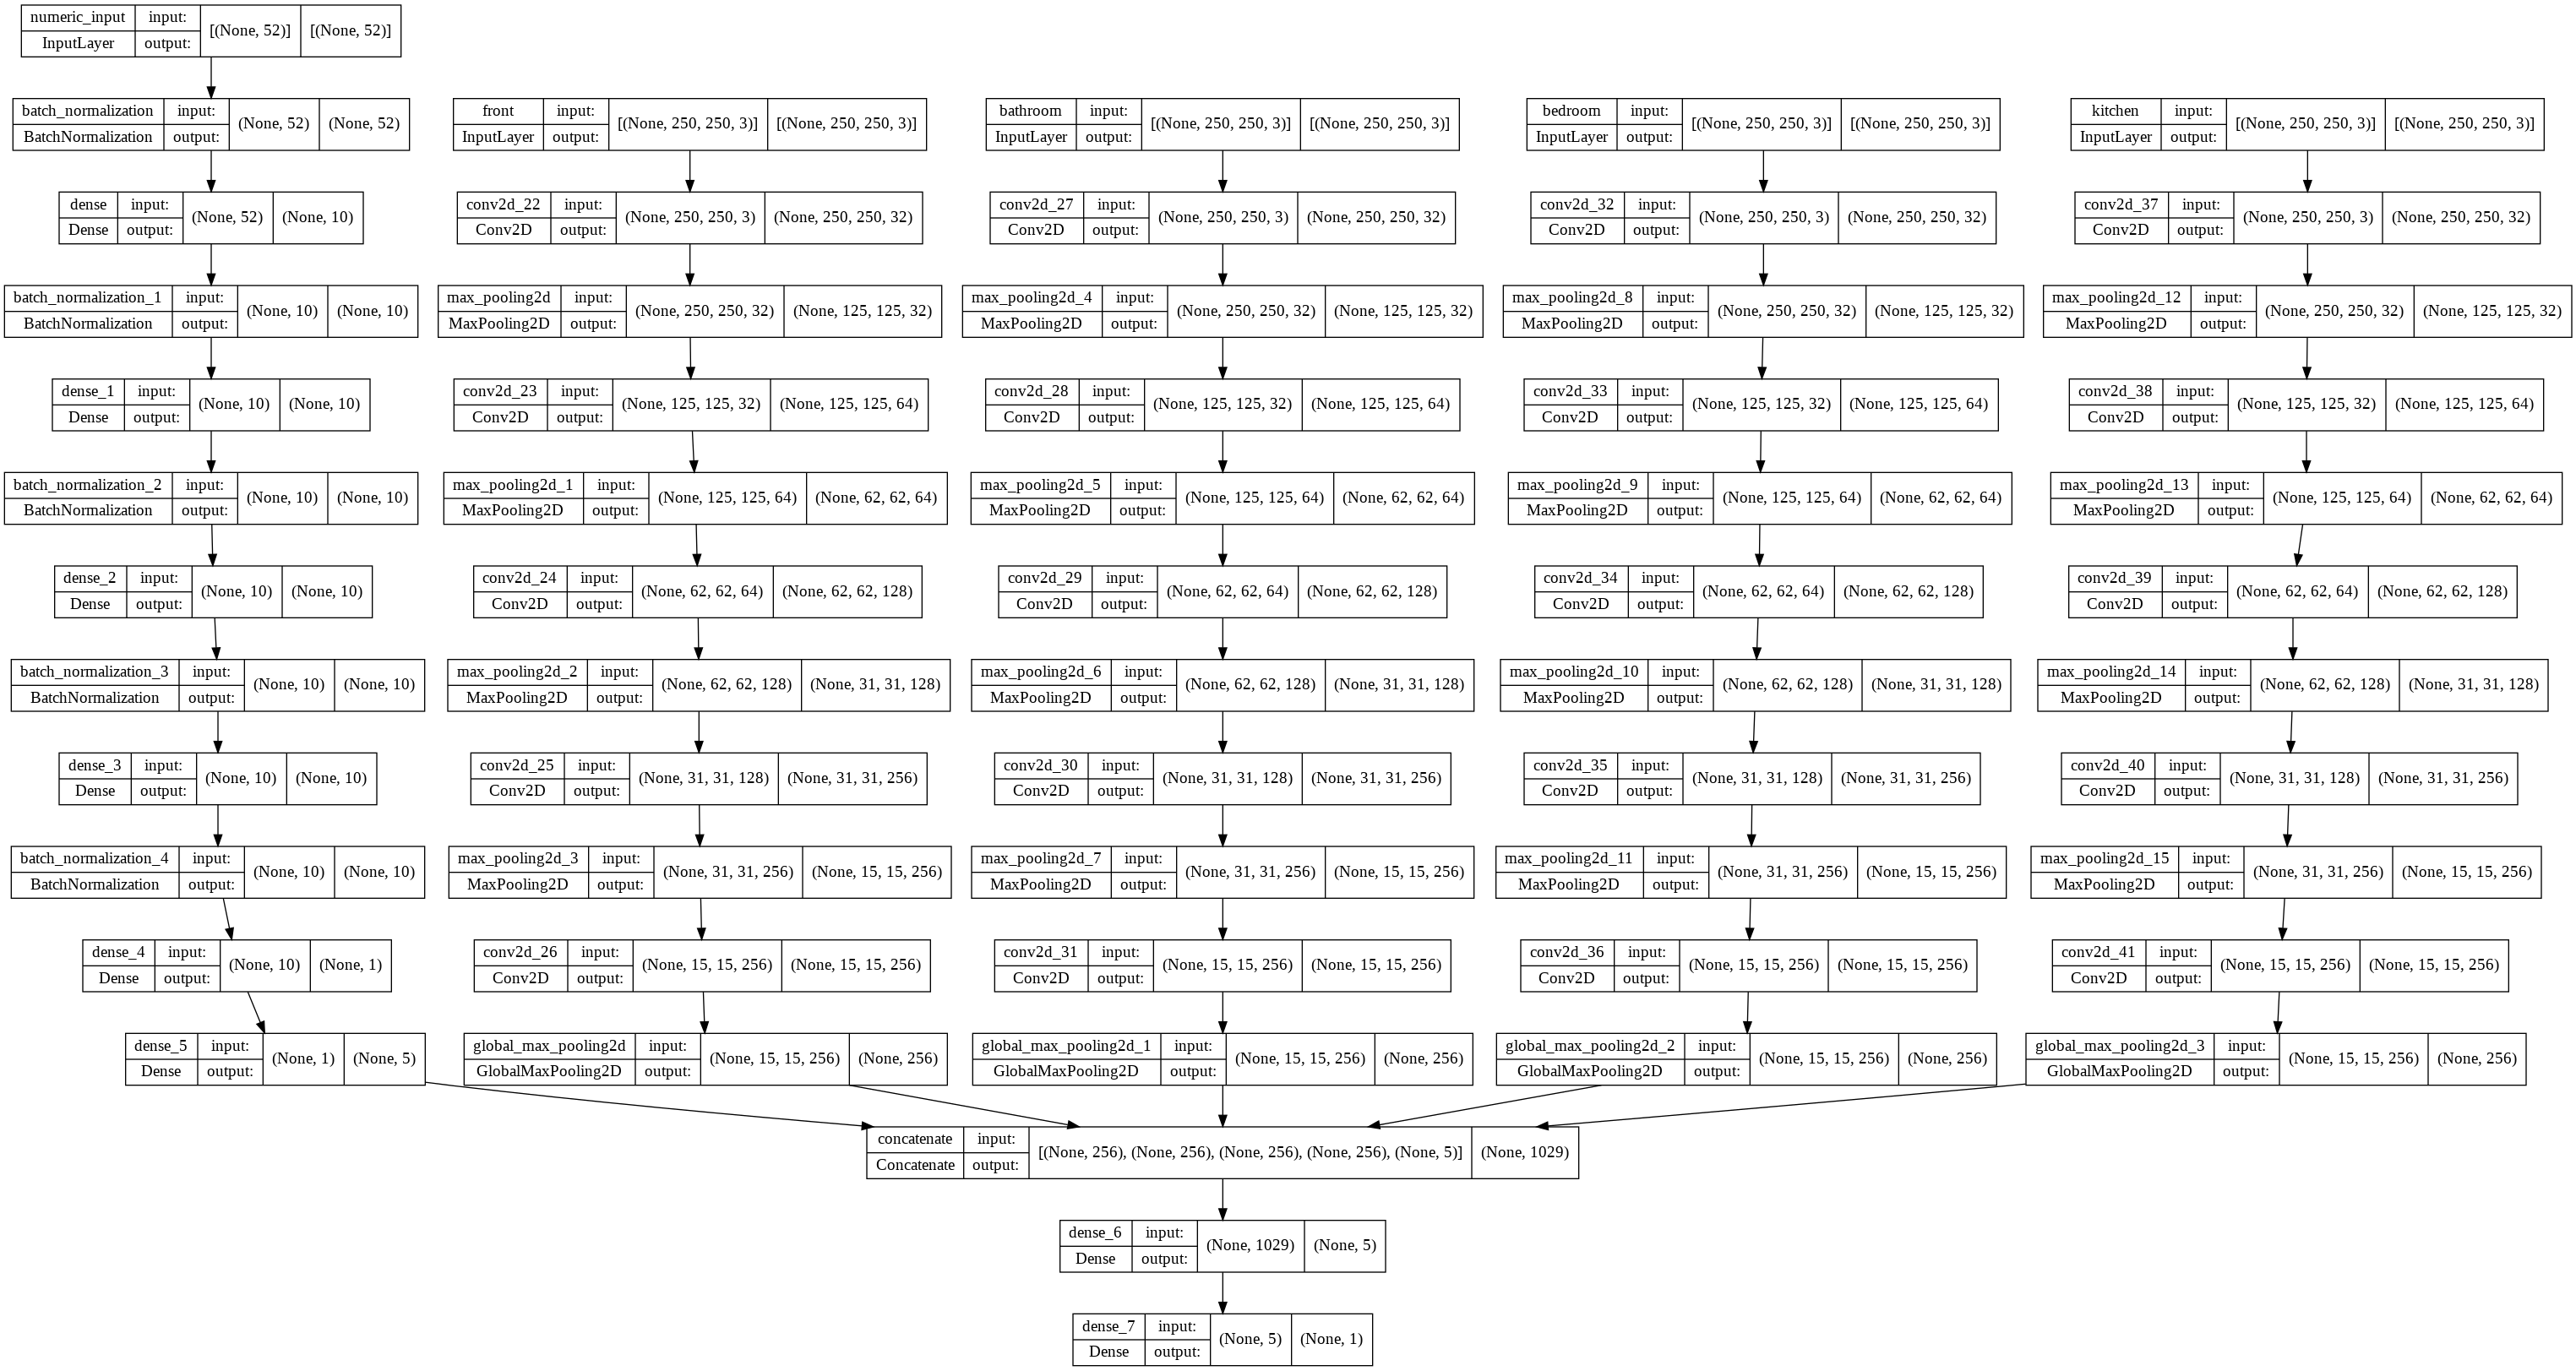

In [12]:
model.summary()
keras.utils.plot_model(model, show_shapes=True)

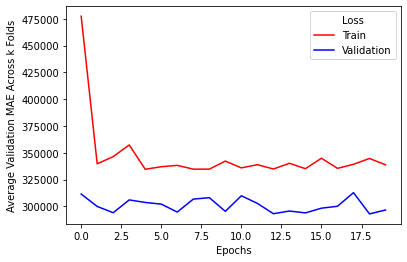

In [13]:
train_mae_history = history.history['loss']
val_mae_history = history.history['val_loss']


plt.plot(train_mae_history, c="r")
plt.plot(val_mae_history,c="b")
plt.legend(['Train','Validation'],title="Loss")
plt.xlabel("Epochs")
plt.ylabel("Average Validation MAE Across k Folds")
plt.show()

#*Fit Your Model*

Train your model and track validation loss in terms of MAE. You must use 5-fold cross-validation here. I will evaluate your model's performance in terms of best average validation loss.

In [ ]:
### PROVIDE YOUR CODE TO EVALUATE FIT / EVALUATE YOUR MODEL'S ACCURACY

folds = 5
num_val_samples = len(variables) // folds # floor division (i.e., round down to nearest integer.)
num_epochs = 100
batch_sizes = 8
all_train_mae_histories, all_val_mae_histories = [],[]  

for i in range(folds): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    
    val_data1 = front_image[i * num_val_samples: (i + 1) * num_val_samples]
    val_data2 = bathroom_image[i * num_val_samples: (i + 1) * num_val_samples]
    val_data3 = bedroom_image[i * num_val_samples: (i + 1) * num_val_samples]
    val_data4 = kitchen_image[i * num_val_samples: (i + 1) * num_val_samples]
    val_data5 = variables[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data1 = np.concatenate(
        [front_image[:i * num_val_samples],
         front_image[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_data2 = np.concatenate(
        [bathroom_image[:i * num_val_samples],
         bathroom_image[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_data3 = np.concatenate(
        [bedroom_image[:i * num_val_samples],
         bedroom_image[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_data4 = np.concatenate(
        [kitchen_image[:i * num_val_samples],
         kitchen_image[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_data5 = np.concatenate(
        [variables[:i * num_val_samples],
         variables[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [labels[:i * num_val_samples],
         labels[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()

    history = model.fit(x=[partial_train_data1, partial_train_data2, partial_train_data3, partial_train_data4, partial_train_data5], y=partial_train_targets,
                        validation_data=([val_data1,val_data2,val_data3,val_data4,val_data5], val_targets),
                        epochs=num_epochs, batch_size=batch_sizes)
    
    train_mae_history = history.history['mae']
    val_mae_history = history.history['val_mae']

    all_train_mae_histories.append(train_mae_history)
    all_val_mae_histories.append(val_mae_history)

average_train_mae_history = [np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]
average_val_mae_history = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

Processing fold #: 0
Epoch 1/100
13/54 [======>.......................] - ETA: 2:23 - loss: 531763.4375 - mae: 531763.4375

KeyboardInterrupt: ignored

Plot your model's loss over epochs to undertand fitting / overfitting.

In [ ]:
plt.plot(average_train_mae_history, c="r")
plt.plot(average_val_mae_history,c="b")
plt.legend(['Train','Validation'],title="Loss")
plt.xlabel("Epochs")
plt.ylabel("Average Validation MAE Across k Folds")
plt.show()

#**Now Use a Pre-Trained Model (10 points)**

In this section, you should replace the CNN components of your 'from-scratch' multi-modal network with a pre-trained model. You can use any pre-trained model you like to pre-process your images into numeric vectors, and then feed those vectors into a standard, dense feed-forward NN to generate predictions. 

#*Load Pre-Trained Model's CNN layers*

In [ ]:
# YOUR CODE HERE TO LOAD THE PRE-TRAINED MODEL

from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (200, 200, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

#*Pre-process Your Images Through the Pre-trained Model's CNN Layers*

You need to write a quick function that loops over your images and runs them through the pre-trained CNN layers to get back the numeric vector representations.

In [ ]:
## YOUR CODE HERE TO PROCESS IMAGES THROUGH THE PRE-TRAINED MODEL AND STORE THEIR FEATURE VECTORS

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'mae',metrics = ['mae'])
vgghist = model.fit(x=[front_image, bathroom_image, bedroom_iamge, kitchen_image, variables], y=labels, validation_split=0.33, epochs=num_epochs, batch_size=50)

# Recall we already created labels and homeFeatures data earlier, which are still numpy arrays in memory.
#print(homeFeatures.shape)
#print(labels.shape)



# Recall we already created labels and homeFeatures data earlier, which are still numpy arrays in memory.
print(homeFeatures.shape)
print(labels.shape)

#*Define Your Dense Network (That Accepts the Image's Feature Vectors)*

You will once again have a multi-branch network, but you've no longer any need for CNNs here. Just use Dense layers for each branch of input, and merge the branches together before producing a numeric prediction. Of course you may want to add elements to address overfitting.

In [ ]:
def build_model_preTrain():

    ### YOUR CODE HERE TO BUILD A DENSE NETWORK ON THE FLY

    model_preTrain.compile(loss="mae", optimizer="adam")

    return model_preTrain

#*Fit Your Dense Model*

Again, make sure you employ 5-fold cross validation, and employ MAE as your loss function.

In [ ]:
### YOUR CODE HERE TO EVALUATE ACCURACY LEVERAGING THE PRE-TRAINED MODEL

Finally, plot your model's validation loss over training. 

In [ ]:
import matplotlib.pyplot as plt

# Fill this in.